# Preterm Infant Cardio-Respiratory Signals Database

Source: https://physionet.org/content/picsdb/1.0.0/

## Python prelude

Import basic packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb # read Physionet/picsdb file format
from picsdb import *
from wfdb import processing
from numba import jit


## PART 1: Initial Inspection

### Data import

**Assumption**: data directory is in the current folder and has not been renamed after download from Physionet.  
 (Adapt if necessary)

In [2]:
#base_dir = os.getcwd()
#data_dir = os.path.join(base_dir, "preterm-infant-cardio-respiratory-signals-database-1.0.0")
#print("base directory: ", base_dir)
#print("data directory: ", data_dir)
data_dir="/Users/lyl69/Desktop/Sets/"

Make a list of all files in this directory, used later to iterate over all files.

In [3]:
L = os.listdir(data_dir)
for l in L:
    print(l)


ANNOTATORS
infant10_ecg.atr
infant10_ecg.dat
infant10_ecg.hea
infant10_ecg.qrsc
infant10_resp.dat
infant10_resp.hea
infant10_resp.resp
infant1_ecg.atr
infant1_ecg.dat
infant1_ecg.hea
infant1_ecg.qrsc
infant1_resp.dat
infant1_resp.hea
infant1_resp.resp
infant2_ecg.atr
infant2_ecg.dat
infant2_ecg.hea
infant2_ecg.qrsc
infant2_resp.dat
infant2_resp.hea
infant2_resp.resp
infant3_ecg.atr
infant3_ecg.dat
infant3_ecg.hea
infant3_ecg.qrsc
infant3_resp.dat
infant3_resp.hea
infant3_resp.resp
infant4_ecg.atr
infant4_ecg.dat
infant4_ecg.hea
infant4_ecg.qrsc
infant4_resp.dat
infant4_resp.hea
infant4_resp.resp
infant5_ecg.atr
infant5_ecg.dat
infant5_ecg.hea
infant5_ecg.qrsc
infant5_resp.dat
infant5_resp.hea
infant5_resp.resp
infant6_ecg.atr
infant6_ecg.dat
infant6_ecg.hea
infant6_ecg.qrsc
infant6_resp.dat
infant6_resp.hea
infant6_resp.resp
infant7_ecg.atr
infant7_ecg.dat
infant7_ecg.hea
infant7_ecg.qrsc
infant7_resp.dat
infant7_resp.hea
infant7_resp.resp
infant8_ecg.atr
infant8_ecg.dat
infant8_ecg.he

### Manual file selection

var = file_index from 1 to 10
freq


Select one file manually for inspection and loaded with help of the wfdb library:

In [4]:
file_index = 3
file_ecg = os.path.join(data_dir, f"infant{file_index:d}_ecg")
file_resp = os.path.join(data_dir, f"infant{file_index:d}_resp")
print("Loading ECG file : ", file_ecg)
print("Loading RESP file: ", file_resp)
record_ecg = wfdb.rdrecord(file_ecg)
record_resp = wfdb.rdrecord(file_resp)


Loading ECG file :  /Users/lyl69/Desktop/Sets/infant3_ecg
Loading RESP file:  /Users/lyl69/Desktop/Sets/infant3_resp


The loaded files contain lots of metadata, the actual ECG/RESP waveforms are stored as arrays.  
The `wfdb` package stored metadata and data in its own format `wfdb.io.record.Record`, but can be retrieved as a Python dictionary (`dict`):

In [5]:
d_ecg = record_ecg.__dict__
d_resp = record_resp.__dict__
print(d_ecg)

{'record_name': 'infant3_ecg', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 78684614, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['II'], 'p_signal': array([[ 0.09467079],
       [ 0.09993028],
       [ 0.09467079],
       ...,
       [-0.83976496],
       [-0.91427437],
       [-0.94407814]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['infant3_ecg.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1140.7954], 'baseline': [11394], 'units': ['mV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [11502], 'checksum': [22904], 'block_size': [0]}


Some useful parameters are stored under the following keys: 

In [6]:
print("ECG record: ", d_ecg['record_name'])
print("number of signals: ", d_ecg['n_sig'])
print("sampling frequency: ", d_ecg['fs'], "Hz")
print("Number of samples: ", d_ecg['sig_len'])
print("Signal name: ", d_ecg['sig_name'])

ECG record:  infant3_ecg
number of signals:  1
sampling frequency:  500 Hz
Number of samples:  78684614
Signal name:  ['II']


In [7]:
print("RESP record: ", d_resp['record_name'])
print("number of signals: ", d_resp['n_sig'])
print("sampling frequency: ", d_resp['fs'], "Hz")
print("Number of samples: ", d_resp['sig_len'])
print("Signal name: ", d_resp['sig_name'])

RESP record:  infant3_resp
number of signals:  1
sampling frequency:  50 Hz
Number of samples:  7868296
Signal name:  ['RESP']


**NOTE**: not all the records use the same sampling frequency, you should therefore read the sampling frequency from the metadata.

Next, extract the ECG/RESP data arrays and convert them into 1-dimensional arrays using `ravel`:

In [8]:
x_ecg = d_ecg['p_signal'].ravel()
print("Number of ECG samples: ", x_ecg.shape[0], " data type: ", x_ecg.dtype)

Number of ECG samples:  78684614  data type:  float64


In [9]:
x_resp = d_resp['p_signal'].ravel()
print("Number of RESP samples: ", x_resp.shape[0], " data type: ", x_resp.dtype)

Number of RESP samples:  7868296  data type:  float64


Store the sampling rates as separate variables:

In [10]:
fs_ecg = d_ecg['fs'] # ECG sampling rate in Hz
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
fs_resp = d_resp['fs'] # RESP sampling rate in Hz
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling frequency: ", fs_ecg, " Hz")
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling frequency: ", fs_resp, " Hz")
print("RESP sampling interval dt = ", dt_resp, " sec.")

ECG sampling frequency:  500  Hz
ECG sampling interval dt =  0.002  sec.
RESP sampling frequency:  50  Hz
RESP sampling interval dt =  0.02  sec.


### Select time window manually

In [11]:
# set display time limits manually, recordings are many hours, millions of data points...
#t0_sec, t1_sec = 90620, 90640 # seconds

# ...or, if you want to look at the whole recording:
t0_sec, t1_sec = 0, x_resp.shape[0]*dt_resp # seconds, based on RESP signal

# convert seconds to samples, respect different sampling rates for ECG and RESP signals
t0_sample_ecg = round(t0_sec * fs_ecg)
t1_sample_ecg = round(t1_sec * fs_ecg)
t0_sample_resp = round(t0_sec * fs_resp)
t1_sample_resp = round(t1_sec * fs_resp)

Plot the result in an external window for inspection:

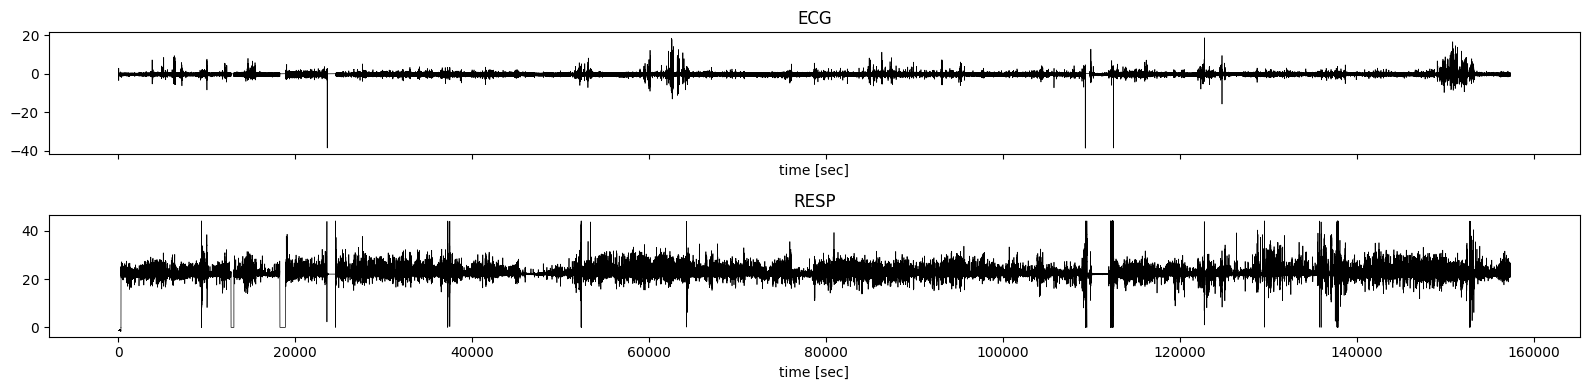

In [12]:
# this tells the notebook to open figures outside of the notebook
#%matplotlib qt
%matplotlib inline

time_ecg = np.arange(x_ecg.shape[0])*dt_ecg # ECG time axis
time_resp = np.arange(x_resp.shape[0])*dt_resp # RESP time axis

fig1, ax = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ax[0].plot(time_ecg[t0_sample_ecg:t1_sample_ecg], x_ecg[t0_sample_ecg:t1_sample_ecg], '-k', lw=0.5)
ax[1].plot(time_resp[t0_sample_resp:t1_sample_resp], x_resp[t0_sample_resp:t1_sample_resp], '-k', lw=0.5)
ax[0].set_xlabel("time [sec]")
ax[1].set_xlabel("time [sec]")
ax[0].set_title("ECG")
ax[1].set_title("RESP")
plt.tight_layout()
plt.show()

## PART 2: Selection of Sample Segments

Use the manually selected segment borders (in seconds) that were identified visually using `picsdb1_inspect.ipynb`:

In [13]:
#A
segments = {}
for i in range(10):
    key = f"infant{i+1:d}"
    segments[key] = []
#segments['infant1'] = [(3550, 3750), (4720,4822), (5100,5280), (7760,7870), (11435,11550)]
#segments['infant1'] = [(3550,7870)]
segments['infant2'] = [(3990,12080)]
segments['infant1'] = [(5110,11550)]
segments['infant3'] = [(5575,13940)]
segments['infant4'] = [(5860,12980)]
segments['infant5'] = [(103750,147350)] #FINAL
segments['infant6'] = [(7130,13670)]
segments['infant7'] = [(5060,13630)]
segments['infant8'] = [(4880,14570)]
segments['infant9'] = [(5940,12580)]
segments['infant10'] = [(3225,14710)]

## PART 3: Selecting thresholds for peak detection for each sample

Part 3 will be re-ran every segement. The final thresholds selected will be recorded in columns D to K of 'Preterm Infant Data Input Settings Blank' excel spreadsheet.

Our complete and filled out excel spreadsheet is titled 'Preterm Infant Data Input Settings'. Refer to that if wanting to produce our exact results.

**Step One: Select segement to work with**

Select a segment to work with by entering in an Infant number/ file_index (1 to 10) and a segement number

file_index = 2 # 1...10, loads data from infant1 ... infant10
segment_index = 0

In [14]:
file_index = 9# 1...10, loads data from infant1 ... infant10
segment_index = 0 # 0,...

**Step Two: Import all the revelent data for that segement**

Similar to part 1, the data will be imported but only part of the signal. Part 2, Step Two created a dictionary that will be used so the correct segment of time is selected from the overall signal and Part 3, Step One determines which segment it is.

## Data import

In [15]:
x_ecg_full, x_resp_full, fs_ecg, fs_resp = load_waveforms(data_dir, file_index)
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling interval dt = ", dt_resp, " sec.")

Loading ECG file:  infant9_ecg
Loading RESP file:  infant9_resp
ECG sampling frequency:  500  Hz
RESP sampling frequency:  50  Hz
ECG sampling interval dt =  0.002  sec.
RESP sampling interval dt =  0.02  sec.


Clip data to segment borders:

In [16]:
# get segment borders in seconds from the 'segments' dictionary
t0_sec, t1_sec = segments[f"infant{file_index:d}"][segment_index]
# convert seconds to samples, respect different sampling rates for ECG and RESP signals
t0_sample_ecg = round(t0_sec * fs_ecg)
t1_sample_ecg = round(t1_sec * fs_ecg)
t0_sample_resp = round(t0_sec * fs_resp)
t1_sample_resp = round(t1_sec * fs_resp)

Extract the ECG and RESP data arrays and convert them to a 1-dimensional arrays:

In [17]:
x_ecg = x_ecg_full[t0_sample_ecg:t1_sample_ecg] #sample for ecg
x_resp = x_resp_full[t0_sample_resp:t1_sample_resp]
print("number of ECG samples: ", len(x_ecg) , " data type: ", x_ecg.dtype)
print("number of RESP samples: ", x_resp.shape[0], " data type: ", x_resp.dtype)


number of ECG samples:  3320000  data type:  float64
number of RESP samples:  332000  data type:  float64


In [18]:
del x_ecg_full, x_resp_full # free memory

Invert ECG signal if necessary.

mn = np.min(x_ecg-np.median(x_ecg))
mx = np.max(x_ecg-np.median(x_ecg))
if np.abs(mn) > np.abs(mx):
    print("Invert ECG signal!")
    x_ecg = -x_ecg

**Step Three: Plot the signal to check the segment selected**

**Step Four: Define a few functions to process the signal with**

- A) Bandwidth filter (filters out extreme frequency signals that are out of what's is physically possible)
- B) Local Maxima- to detect the peak of a wave
- C) Histogram- to look at distribution 
- D) Interval Statistics 

**NOTE**: These functions have been moved from the notebook into the external file `picsdb.py`

# ECG/RESP peak detection algorithm

## Plot power spectra

First, inspect the power spectral densities of ECG/RESP signals to get an idea of useful settings for the band-pass filters.

**Resample the ecg sig**

In [19]:
freq_lo_ecg = 20
freq_hi_ecg = 125 # if is 1 or 5, use 120
freq_lo_resp = 0.5
freq_hi_resp = 5 # 5
x_ecg_filt  = bp_filter(x_ecg, fs_ecg, freq_lo_ecg, freq_hi_ecg)
x_ecg=x_ecg_filt
x_resp_filt = bp_filter(x_resp, fs_resp, freq_lo_resp, freq_hi_resp)
x_resp=x_resp_filt

In [20]:
if(fs_resp!=50):
    x_resp=processing.resample_sig(x_resp,fs=fs_resp,fs_target=50)
    fs_resp=50
    dt_resp=1/fs_resp

base on ecg and resp freq

In [21]:
len(x_ecg)

3320000

In [22]:
len(x_resp)

332000

In [23]:
x_resp_flow=[]
x_ecg_flow=[]
resp_counter=int(5/dt_resp)
ecg_counter=int(5/dt_ecg)
resp_index=int(5/dt_resp)
ecg_index=int(5/dt_ecg)
ecg_temp=[]
resp_temp=[]
count_resp=int(len(x_resp)/resp_counter)
count_ecg=int(len(x_ecg)/ecg_counter)
start=int(0)
for i in range(count_resp):
    temp=x_resp[start:resp_index]
    x_resp_flow.append(temp)
    start=resp_index
    resp_index=int(resp_index+resp_counter)
    temp=[]
start=int(0)
for j in range(count_ecg):
    temp=x_ecg[start:ecg_index]
    x_ecg_flow.append(temp)
    start=ecg_index
    ecg_index=int(ecg_index+ecg_counter)
    temp=[]

**Get the single resp wave**

In [24]:
print(len(x_resp)/resp_counter)
print(len(x_ecg)/ecg_counter)
print(len(x_resp_flow))
print(len(x_ecg_flow))
print(len(x_resp_flow[2]))
print(len(x_ecg_flow[15]))

1328.0
1328.0
1328
1328
250
2500


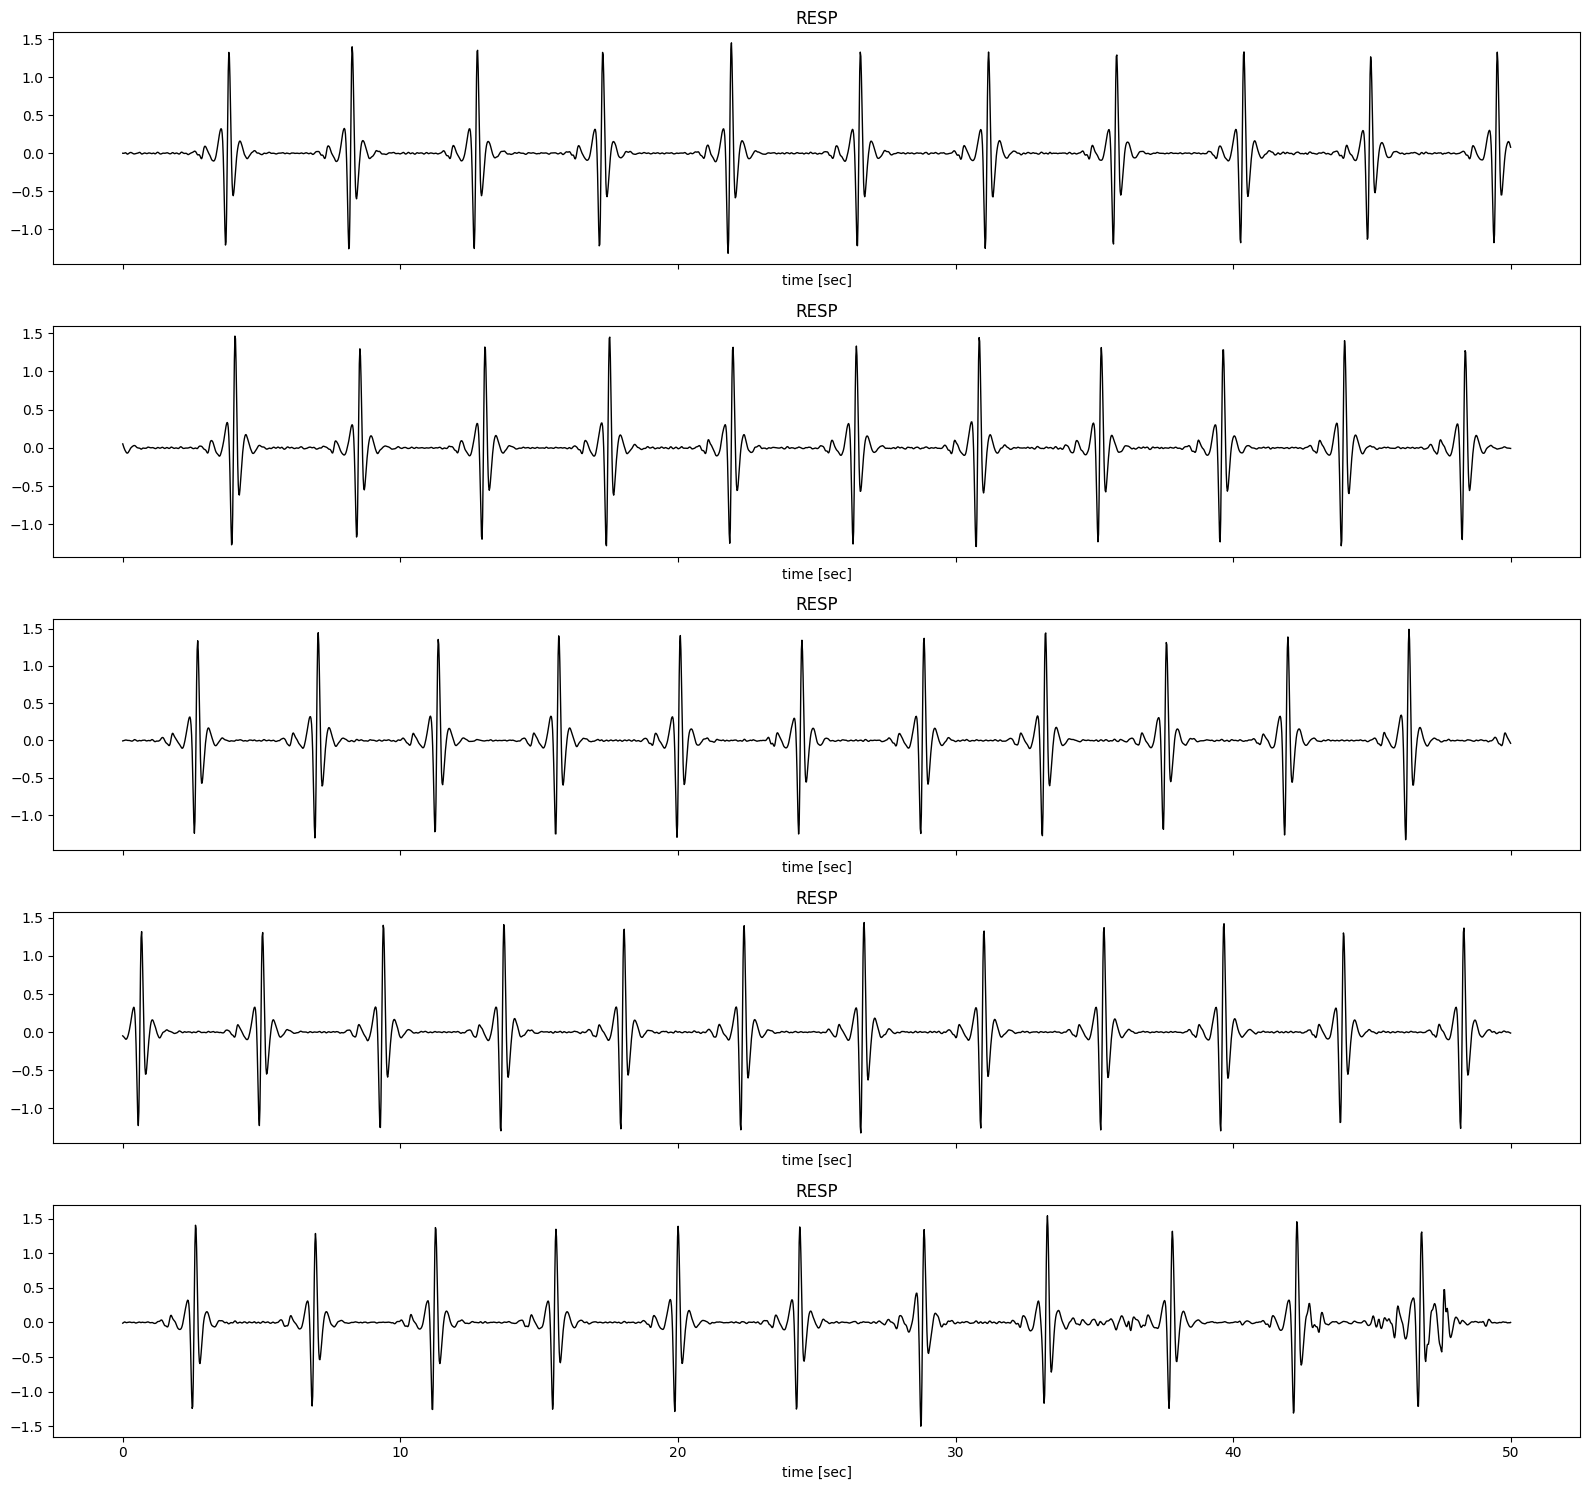

In [25]:

time_line = np.arange(len(x_ecg_flow[0]))*dt_resp
fig2, ax = plt.subplots(5, 1, figsize=(16,15), sharex=True)
#x_resp_flow.remove(x_resp_flow[0])
#x_temp.remove(x_temp[0])
#x_ecg_flow.remove(x_ecg_flow[0])
j=0
for i in range(0,5):
    ax[j].plot(time_line, x_ecg_flow[i], '-k', lw=1)
    ax[j].set_xlabel("time [sec]")
    ax[j].set_title("RESP")
    j+=1

plt.tight_layout()
plt.show()

**conbain the uncontinue data**

**remove some data**

I still working on finding someway to fix the discontinuous data, so I drop them.

If we can combain the discontinuous data, this function can be delete

**find the R wave for each part ecg wave**

In [26]:
lomx=[]
w=1
for z in x_ecg_flow:
    c=locmax(z)
    ecg_peaks = np.array([np.mean(z[i-w:i+w]) for i in c])
    c = np.array([j for i, j in enumerate(c) if ecg_peaks[i] >1.0]) #ecg_peacks > 0.12 / 0.2
    lomx.append(c)
print(len(lomx))


1328


In [27]:
lomx

[array([ 191,  413,  639,  864, 1096, 1328, 1559, 1790, 2019, 2247, 2475],
       dtype=int64),
 array([ 202,  427,  652,  877, 1099, 1321, 1542, 1762, 1982, 2200, 2417],
       dtype=int64),
 array([ 135,  352,  568,  785, 1004, 1223, 1443, 1662, 1879, 2098, 2316],
       dtype=int64),
 array([  34,  252,  469,  686,  903, 1119, 1335, 1551, 1767, 1983, 2198,
        2415], dtype=int64),
 array([ 131,  347,  563,  780, 1000, 1219, 1443, 1665, 1890, 2114, 2339],
       dtype=int64),
 array([  63,  287,  512,  737,  963, 1189, 1416, 1642, 1870, 2099, 2326],
       dtype=int64),
 array([  56,  286,  514,  740,  966, 1191, 1415, 1638, 1859, 2081, 2302],
       dtype=int64),
 array([  23,  243,  463,  683,  907, 1131, 1360, 1588, 1814, 2040, 2267,
        2495], dtype=int64),
 array([ 224,  453,  681,  909, 1136, 1364, 1591, 1818, 2044, 2269, 2495],
       dtype=int64),
 array([ 221,  446,  672,  897, 1121, 1345, 1570, 1794, 2018, 2241, 2465],
       dtype=int64),
 array([ 188,  409,  631, 

**compute the rate for each ecg wave**


In [28]:
timespan=d_ecg #ms
rate=[]
for i in lomx:
    if not len(i)==0:
        span=dt_ecg*(max(i)-min(i))/(len(i)-1)
        rate.append(60/span)
    else:
        rate.append(0)

C:\Users\lyl69\AppData\Local\Temp\ipykernel_33484\4290182661.py:5: RuntimeWarning: invalid value encountered in double_scalars
  span=dt_ecg*(max(i)-min(i))/(len(i)-1)


In [29]:
rate

[131.34851138353764,
 135.44018058690747,
 137.55158184319117,
 138.59722805543888,
 135.86956521739128,
 132.5673884224481,
 133.5707925200356,
 133.49514563106797,
 132.1003963011889,
 133.6898395721925,
 135.13513513513513,
 133.92857142857142,
 134.04825737265415,
 135.91433278418452,
 134.52914798206277,
 129.98266897746967,
 132.9787234042553,
 127.96208530805688,
 127.82275244993609,
 129.75778546712803,
 127.90146849834201,
 133.8199513381995,
 138.44023996308258,
 140.72494669509595,
 138.05798435342845,
 134.03736799350122,
 130.8139534883721,
 131.75230566534913,
 135.02454991816694,
 131.63668275559456,
 135.4062186559679,
 99.38476100331282,
 72.81553398058253,
 40.816326530612244,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 nan,
 0,
 0,
 0,
 0,
 0,
 69.93006993006993,
 0,
 142.85714285714286,
 0,
 0,
 15.71503404924044,
 19.569471624266143,
 nan,
 0,
 nan,
 nan,
 0,
 0,
 nan,
 0,
 0,
 33.222591362126245,
 nan,
 nan,
 nan,
 0,
 0,
 0,
 0,
 138.88888888888889,
 0,
 nan,
 nan,
 27.54820936

In [30]:

arr = np.nan_to_num(rate)
nanlist=[]

for i in range(len(arr)):
    if arr[i]<50 or arr[i]>190:
        nanlist.append(i)
finalrate=[]
if(not len(nanlist)==0):
    j=0
    for i in range(len(arr)):
        if j==len(nanlist):
            break
        if i==nanlist[j]:
            j+=1
            pass
        else:
            finalrate.append(arr[i])
        
    finalresp=[]
    y=0
    for z in range(len(x_resp_flow)):
        if y==len(nanlist):
            break
        if z==nanlist[y]:
            y+=1
            pass
        else:
            finalresp.append(x_resp_flow[z])
else:
    finalrate=arr
    finalresp=x_resp_flow

In [31]:
len(finalresp)

318

**next step: remove incomplete ecg data for resp and ecg wave**

finalrate

finalresp

In [256]:
import csv

#python2可以用file替代open
with open("test_09.csv","w", newline="") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerows(finalresp)

In [257]:
for i in finalrate:
    print(i)

131.34851138353764
135.44018058690747
137.55158184319117
138.59722805543888
135.86956521739128
132.5673884224481
133.5707925200356
133.49514563106797
132.1003963011889
133.6898395721925
135.13513513513513
133.92857142857142
134.04825737265415
135.91433278418452
134.52914798206277
129.98266897746967
132.9787234042553
127.96208530805688
127.82275244993609
129.75778546712803
127.90146849834201
133.8199513381995
138.44023996308258
140.72494669509595
138.05798435342845
134.03736799350122
130.8139534883721
131.75230566534913
135.02454991816694
131.63668275559456
135.4062186559679
99.38476100331282
72.81553398058253
69.93006993006993
142.85714285714286
138.88888888888889
66.81514476614699
50.561797752808985
50.30743432084963
131.57894736842104
68.4931506849315
68.64988558352402
129.3103448275862
127.6595744680851
131.57894736842104
63.73937677053825
84.86562942008487
86.45533141210373
128.75536480686694
128.4796573875803
137.61467889908258
129.3103448275862
96.98275862068965
55.55555555555555

In [258]:
print(esganoijkc)


NameError: name 'esganoijkc' is not defined

In [260]:
import numpy as np
import pandas as pd
import glob
import re
csv_list = glob.glob('*.csv')
print('发现%s个CSV文件'% len(csv_list))
print('对文件进行处理中')
for i in csv_list:
    fr = open(i,'r',encoding='utf-8').read()
    with open('合并之后.csv','a',encoding='utf-8') as f:
        f.write(fr)
print('所有文件合并完成！')

发现7个CSV文件
对文件进行处理中
所有文件合并完成！


freq_lo_ecg = 20
freq_hi_ecg = 125 # if is 1 or 5, use 120
freq_lo_resp = 0.5
freq_hi_resp = 5 # 5
time_ecg = np.arange(x_ecg.shape[0])*dt_ecg*1000
time_resp = np.arange(x_resp.shape[0])*dt_resp
plt.figure(figsize=(16,5))
plt.scatter(time_ecg, x_ecg, color = 'hotpink',s=2)
#plt.scatter(time_resp, x_resp, color = '#88c999')
x_ecg_filter=bp_filter(x_ecg, fs_ecg, freq_lo_ecg, freq_hi_ecg)
plt.xlabel("TIME STAMP")
plt.ylabel("Signal")
plt.scatter(time_ecg, x_ecg_filter, color = 'green',s=2)
plt.title("Fliter function")
plt.show()